In [35]:
# 전처리 패키지
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


# 모델링 패키지
from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier


# 모델 평가 및 검증 패키지
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score


# 기타 패키지
import random
import os
from datetime import datetime
import time
import math

In [36]:
train = pd.read_csv('C:/lg_capstone/find_abnormal/data/train_begin.csv')
test = pd.read_csv('C:/lg_capstone/find_abnormal/data/test_begin.csv')
# submission = pd.read_csv('./sample_submission.csv')

In [37]:
all_data = pd.concat([train, test], sort=False)
all_data.reset_index(drop=True, inplace=True) # all_data의 인덱스를 0부터 순차적으로 변경(concat하면 index가 중복될 수 있기 때문에 reset_index() 사용)

## 인코딩(범주형 -> 수치형)

In [38]:
# 1. 범주형 컬럼들을 Label Encoding하기
le = LabelEncoder()

# 1) Equipment_Suffix 컬럼을 Label Encoding하기
suffixes = ['Dam', 'Fill1', 'Fill2']
for suffix in suffixes:
    for column in [f'Equipment_{suffix}']:
        all_data[column] = all_data[column].astype(str)
        le.fit(all_data[column])
        all_data[column] = le.transform(all_data[column])


# 2) Model.Suffix_Dam, Workorder_Dam 컬럼을 Label Encoding하기
li = ['Model.Suffix_Dam','Workorder_Dam']
for column in li:
    all_data[column] = all_data[column].astype(str)
    le.fit(all_data[column])
    all_data[column] = le.transform(all_data[column])


# 3) Chamber Temp. Judge Value_AutoClave(탈포 판단값) 컬럼을 Label Encoding하기
all_data['Chamber Temp. Judge Value_AutoClave'] = all_data['Chamber Temp. Judge Value_AutoClave'].astype(str)
le.fit(all_data['Chamber Temp. Judge Value_AutoClave'])
all_data['Chamber Temp. Judge Value_AutoClave'] = le.transform(all_data['Chamber Temp. Judge Value_AutoClave'])


# 4) GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave 컬럼을 Label Encoding하기
all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].astype(str)
le.fit(all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'])
all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = le.transform(all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'])
all_data = all_data.drop(columns='GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave')

## Equipment(Line #1, #2) 또는 PalletID 또는 Production Qty 중 하나라도 다른 데이터 확인하기

<span style="font-size: 25px">all_data -> same_data & diff_data</span>
<br>
<br>
- same_data: Equipment(Line #1, #2)와 PalletID와 Production Qty가 모두 같은 데이터<br><br>
- diff_data: Equipment(Line #1, #2) 또는 PalletID 또는 Production Qty 중 하나라도 다른 데이터

In [39]:
# Equipment_Dam, Equipment_Fill1, Equipment_Fill2의 값을 비교하여 다르면 해당 데이터의 인덱스를 index_of_diff, 같으면 index_of_same 저장
index_of_diff = []
index_of_same = []

dam_values = all_data['Equipment_Dam'].values
fill1_values = all_data['Equipment_Fill1'].values
fill2_values = all_data['Equipment_Fill2'].values

index_of_diff = np.where((dam_values != fill1_values) | (dam_values != fill2_values))[0].tolist()
index_of_same = np.where((dam_values == fill1_values) & (dam_values == fill2_values))[0].tolist()


# PalletID Collect Result_Dam, PalletID Collect Result_Fill1, PalletID Collect Result_Dam 의 값을 비교하여 다르면 해당 데이터의 인덱스를 index_of_diff, 같으면 index_of_same append
index_of_diff2 = []
index_of_same2 = []

dam_values = all_data['PalletID Collect Result_Dam'].values
fill1_values = all_data['PalletID Collect Result_Fill1'].values
fill2_values = all_data['PalletID Collect Result_Fill2'].values

index_of_diff2 = np.where((dam_values != fill1_values) | (dam_values != fill2_values))[0].tolist()
index_of_same2 = np.where((dam_values == fill1_values) & (dam_values == fill2_values))[0].tolist()


# Production Qty Collect Result_Dam, Production Qty Collect Result_Fill1, Production Qty Collect Result_Fill2의 값을 비교하여 다르면 해당 데이터의 인덱스를 index_of_diff, 같으면 index_of_same append
index_of_diff3 = []
index_of_same3 = []

dam_values = all_data['Production Qty Collect Result_Dam'].values
fill1_values = all_data['Production Qty Collect Result_Fill1'].values
fill2_values = all_data['Production Qty Collect Result_Fill2'].values

index_of_diff3 = np.where((dam_values != fill1_values) | (dam_values != fill2_values))[0].tolist()
index_of_same3 = np.where((dam_values == fill1_values) & (dam_values == fill2_values))[0].tolist()


In [40]:
# 3개의 필터링 결과 합치기
index_of_diff_total = list(set(index_of_diff + index_of_diff2 + index_of_diff3))

# index_of_diff_total의 중복값 제거
index_of_diff_total = list(set(index_of_diff_total))


# index_of_diff_total에 해당하는 데이터를 diff_data에 저장하고, 해당하지 않는 나머지 데이터를 same_data에 저장
diff_data = all_data.loc[index_of_diff_total]
same_data = all_data.drop(index=index_of_diff_total)

In [41]:
# diff_data의 'target' 컬럼이 nan인 행만 추출하여 diff_test에 저장
diff_test = diff_data[diff_data['target'].isnull()]

# diff_test의 'target' 컬럼의 값을 모두 'AbNormal'로 변경
diff_test['target'] = 'AbNormal'

# diff_test의 'Set ID'와 'target' 컬럼만 선택하여 submission_diff에 저장
submission_diff = diff_test[['Set ID', 'target']]

C:\Users\jdh25\AppData\Local\Temp\ipykernel_10260\450733750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_test['target'] = 'AbNormal'


In [42]:
submission_diff.shape

(28, 2)

In [43]:
same_data.shape

(57746, 183)

## same_data 전처리

In [44]:
all_data = same_data

### 불필요한 컬럼 제거하기

In [45]:
unnecessary_columns =['Model.Suffix_AutoClave','Model.Suffix_Fill1','Model.Suffix_Fill2',
    'Workorder_AutoClave','Workorder_Fill1','Workorder_Fill2',
    'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2',]
all_data = all_data.drop(unnecessary_columns , axis=1)

# 열 목록 정의
cols_to_average = ['Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam'
]

# 평균 값 계산 및 새로운 열 추가
# all_data['Average Stage1 Circle Distance Speed Collect Result_Dam'] = all_data[cols_to_average[:4]].mean(axis=1)
# all_data['Average Stage1 Line Distance Speed Collect Result_Dam'] = all_data[cols_to_average[4:8]].mean(axis=1)
# all_data['Average Stage2 Circle Distance Speed Collect Result_Dam'] = all_data[cols_to_average[8:12]].mean(axis=1)
# all_data['Average Stage2 Line Distance Speed Collect Result_Dam'] = all_data[cols_to_average[12:16]].mean(axis=1)
# all_data['Average Stage3 Circle Distance Speed Collect Result_Dam'] = all_data[cols_to_average[16:20]].mean(axis=1)
# all_data['Average Stage3 Line Distance Speed Collect Result_Dam'] = all_data[cols_to_average[20:24]].mean(axis=1)

# all_data['Average Stage1 CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average[:8]].mean(axis=1)
# all_data['Average Stage2 CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average[8:16]].mean(axis=1)
# all_data['Average Stage3 CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average[16:]].mean(axis=1)

# all_data['Average CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average].mean(axis=1)

# 기존 열 삭제
all_data = all_data.drop(columns=cols_to_average)


cols_to_average = [
                'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',

                  'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',

                  'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',        
]

all_data['HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Dam'] = all_data[cols_to_average[:3]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Dam'] = all_data[cols_to_average[3:6]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Dam'] = all_data[cols_to_average[6:9]].mean(axis=1)

all_data['HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill1'] = all_data[cols_to_average[9:12]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Fill1'] = all_data[cols_to_average[12:15]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Fill1'] = all_data[cols_to_average[15:18]].mean(axis=1)


# 기존 열 삭제
all_data = all_data.drop(columns=cols_to_average)


all_data['CURE POSITION X Collect Result_Dam'] = abs(all_data['CURE START POSITION X Collect Result_Dam']-all_data['CURE END POSITION X Collect Result_Dam'])
all_data['CURE POSITION Z Collect Result_Dam'] = abs(all_data['CURE START POSITION Z Collect Result_Dam']-all_data['CURE END POSITION Z Collect Result_Dam'])
all_data['CURE POSITION Θ Collect Result_Dam'] = abs(all_data['CURE START POSITION Θ Collect Result_Dam']-all_data['CURE END POSITION Θ Collect Result_Dam'])

# all_data['CURE TIME X Collect Result_Dam'] = abs(all_data['CURE START POSITION X Collect Result_Dam']-all_data['CURE END POSITION X Collect Result_Dam'])/all_data['CURE SPEED Collect Result_Dam']
# all_data['CURE TIME Z Collect Result_Dam'] = abs(all_data['CURE START POSITION Z Collect Result_Dam']-all_data['CURE END POSITION Z Collect Result_Dam'])/all_data['CURE SPEED Collect Result_Dam']
# all_data['CURE TIME Θ Collect Result_Dam'] = abs(all_data['CURE START POSITION Θ Collect Result_Dam']-all_data['CURE END POSITION Θ Collect Result_Dam'])/all_data['CURE SPEED Collect Result_Dam']

all_data['CURE POSITION X Collect Result_Fill2'] = abs(all_data['CURE START POSITION X Collect Result_Fill2']-all_data['CURE END POSITION X Collect Result_Fill2'])
all_data['CURE POSITION Z Collect Result_Fill2'] = abs(all_data['CURE START POSITION Z Collect Result_Fill2']-all_data['CURE STANDBY POSITION Z Collect Result_Fill2'])+abs(all_data['CURE STANDBY POSITION Z Collect Result_Fill2']-all_data['CURE END POSITION Z Collect Result_Fill2'])

# all_data['CURE TIME X Collect Result_Fill2'] = abs(all_data['CURE START POSITION X Collect Result_Fill2']-all_data['CURE END POSITION X Collect Result_Fill2'])/all_data['CURE SPEED Collect Result_Fill2']
# all_data['CURE TIME Z Collect Result_Fill2'] = (abs(all_data['CURE START POSITION Z Collect Result_Fill2']-all_data['CURE STANDBY POSITION Z Collect Result_Fill2'])+abs(all_data['CURE STANDBY POSITION Z Collect Result_Fill2']-all_data['CURE END POSITION Z Collect Result_Fill2']))/all_data['CURE SPEED Collect Result_Fill2']


# 기존 열 삭제
all_data = all_data.drop(columns=[
                                  'CURE START POSITION X Collect Result_Dam','CURE START POSITION Θ Collect Result_Dam',
                                  'CURE END POSITION X Collect Result_Dam','CURE END POSITION Z Collect Result_Dam','CURE END POSITION Θ Collect Result_Dam','CURE SPEED Collect Result_Dam',
                                  'CURE STANDBY POSITION Z Collect Result_Fill2',
                                  'CURE START POSITION X Collect Result_Fill2','CURE START POSITION Z Collect Result_Fill2',
                                  'CURE END POSITION X Collect Result_Fill2','CURE END POSITION Z Collect Result_Fill2','CURE SPEED Collect Result_Fill2'
                                  ])






all_data['Machine Tact time'] = all_data['Machine Tact time Collect Result_Dam'] + all_data['Machine Tact time Collect Result_Fill1'] + all_data['Machine Tact time Collect Result_Fill2']

all_data = all_data.drop(columns=['Machine Tact time Collect Result_Dam','Machine Tact time Collect Result_Fill1','Machine Tact time Collect Result_Fill2'])

### 비대칭성 높은 칼럼 정규화

In [46]:
a=[]
for c in all_data.columns:
    if all_data[c].nunique()==1:
        a.append(c)
all_data.drop(columns=a, inplace=True)


# 모든 칼럼의 왜도(Skewness) 계산
train_data = all_data[pd.notnull(all_data['target'])]
X = train_data.drop(columns=['target','Set ID'])
skewness = X.skew().sort_values(ascending=False)

# 비대칭성이 높은 칼럼(왜도의 절대값이 1보다 큰 칼럼) 추출
high_skew_cols_list = skewness[abs(skewness) > 1].index.tolist()

# 로그 변환을 위한 작은 상수 추가
epsilon = 1e-6

# 로그 변환을 적용할 칼럼 리스트에서 'PalletID'와 'Production Qty'를 제외
high_skew_cols_list = [col for col in high_skew_cols_list if col not in ['PalletID', 'Production Qty']]

# 로그 변환 적용
for col in high_skew_cols_list:
    if any(all_data[col] <= 0):  # 0 또는 음수 값이 있는 경우 상수 추가
        all_data[col] = np.log1p(all_data[col] + epsilon)
    else:
        all_data[col] = np.log1p(all_data[col])

### 표준화

In [47]:
scaler = StandardScaler()
all_data[high_skew_cols_list] = scaler.fit_transform(all_data[high_skew_cols_list])


### 상관계수 절대값 상위 40개 추출

C:\Users\jdh25\AppData\Local\Temp\ipykernel_10260\1303948143.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['target'] = train_data['target'].astype(str)  # target 변수
C:\Users\jdh25\AppData\Local\Temp\ipykernel_10260\1303948143.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['target'] = le.fit_transform(train_data['target'])  # target 변수를 숫자로 변환


Top 20 Correlations with Target:
target                                                       1.000000
Head Zero Position Y Collect Result_Dam                      0.065833
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam          0.061503
Workorder_Dam                                                0.059662
Head Purge Position Z Collect Result_Fill1                   0.058668
Machine Tact time                                            0.055966
HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill1    0.053628
Head Purge Position Z Collect Result_Dam                     0.052814
Dispense Volume(Stage2) Collect Result_Fill1                 0.051691
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1        0.050961
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam          0.049245
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam          0.048941
Dispense Volume(Stage2) Collect Result_Dam                   0.048226
Dispense Volume(Stage3) Collect Result_Dam               

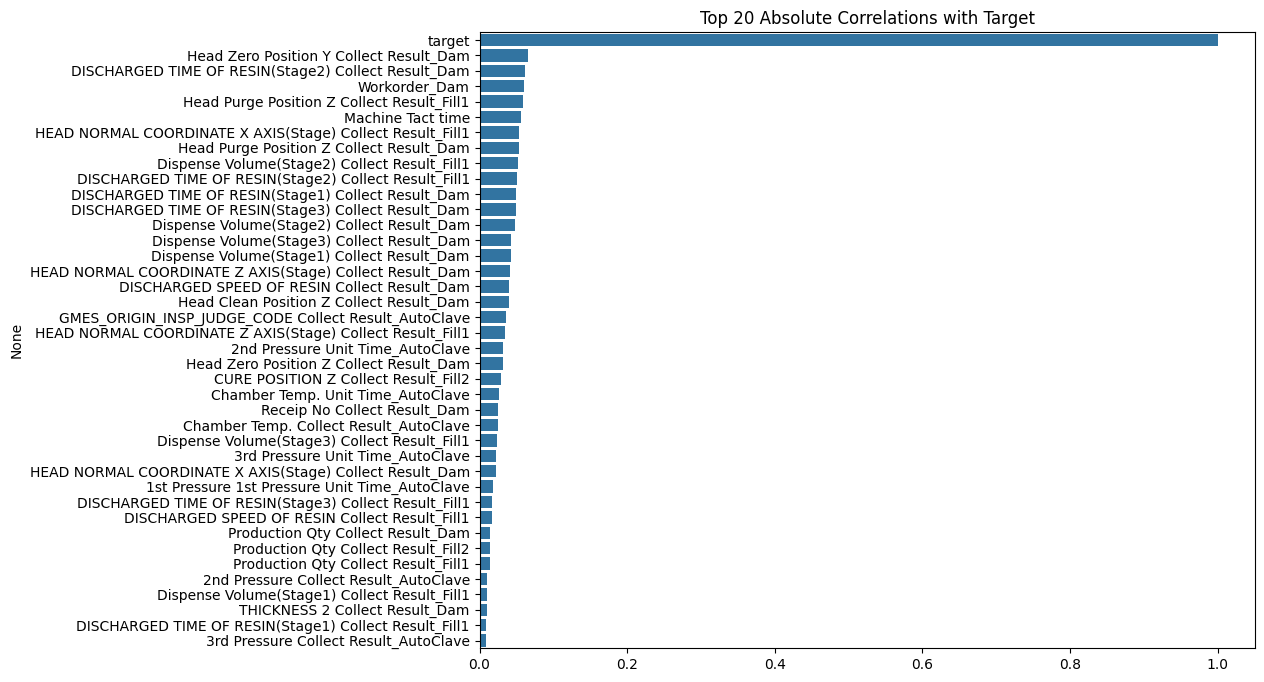

In [50]:
# LabelEncoder 초기화
le = LabelEncoder()

train_data = all_data[pd.notnull(all_data['target'])] # train 데이터 추출: 'target' 컬럼이 NaN이 아닌 데이터

# target과 feature 분리
train_data['target'] = train_data['target'].astype(str)  # target 변수
train_data['target'] = le.fit_transform(train_data['target'])  # target 변수를 숫자로 변환

# 상관계수 계산
correlation_matrix = train_data.corr()

# target과의 상관계수 추출 및 절대값 기준 상위 20개 선택
target_corr = correlation_matrix['target'].abs().sort_values(ascending=False).head(40)

top_10_corr = target_corr.head(20)
print("Top 20 Correlations with Target:")
print(top_10_corr)

# 상위 20개의 피처 목록 추출 (target 포함)
top_features = target_corr.index.tolist()
top_features.append('Equipment_Dam')
# all_data에서 상위 20개의 피처만 선택
all_data_top20 = all_data[top_features]

# 상관계수 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Top 20 Absolute Correlations with Target')
plt.show()


### PCA 적용

all_data_top20 -> pca_features

In [51]:
# all_data_top20 - (target이 null이 아닌 train 데이터 추출) -> train_data - (target 드랍) -> features - (정규화) -> scaled_features - (PCA 적용) -> pca_features

train_data = all_data_top20[pd.notnull(all_data['target'])]

# 타겟 변수를 제외한 피처들만 사용
features = train_data.drop(columns=['target'])

# 데이터 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# PCA 적용
pca = PCA(n_components=0.95)  # 설명 분산의 95%를 유지하도록 설정
pca_features = pca.fit_transform(scaled_features)

# PCA 적용 후 데이터셋의 형태 확인
pca_features_shape = pca_features.shape

# 설명된 분산 비율
explained_variance = pca.explained_variance_ratio_

pca_features_shape, explained_variance

((40413, 18),
 array([0.28200555, 0.1497969 , 0.08425751, 0.07023202, 0.05957751,
        0.04224562, 0.0372437 , 0.03187774, 0.02989321, 0.02566874,
        0.0250461 , 0.02386317, 0.02234858, 0.01850454, 0.01718798,
        0.01401445, 0.0115378 , 0.01072661]))

## SMOTE 적용 및 train_test_split

In [53]:
# 타겟 변수
target = train_data['target']

target = target.astype(str)
target = le.fit_transform(target)

# 데이터 분리 (학습용 80%, 검증용 20%)
X_train, X_val, y_train, y_val = train_test_split(pca_features, target, test_size=0.2, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## 모델1 - 기본 모델 훈련

In [54]:
from sklearn.ensemble import RandomForestClassifier

# 1. 기본 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_smote, y_train_smote)

# 예측
y_pred = model.predict(X_val)

# 성능 평가
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, digits=4)


print("기본 모델 성능")
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

기본 모델 성능
Accuracy: 0.8902635160212792
Classification Report:
               precision    recall  f1-score   support

           0     0.1060    0.1361    0.1192       441
           1     0.9493    0.9338    0.9415      7642

    accuracy                         0.8903      8083
   macro avg     0.5277    0.5349    0.5303      8083
weighted avg     0.9033    0.8903    0.8966      8083



## 모델2 - AbNormal에 가중치 적용해 새로운 모델 훈련

In [55]:
# 1. SMOTE를 적용하여 학습한 랜덤 포레스트 모델
model_weighted_smote = RandomForestClassifier(n_estimators=200, random_state=42, class_weight={0: 1, 1: 10})
model_weighted_smote.fit(X_train_smote, y_train_smote)

# 2. 검증 데이터셋에서 예측 수행
y_pred_weighted_val = model_weighted_smote.predict(X_val)

# 3. 성능 평가
accuracy_weighted_val = accuracy_score(y_val, y_pred_weighted_val)
classification_rep_weighted_val = classification_report(y_val, y_pred_weighted_val, digits=4)

print("SMOTE 적용 모델 성능")
print("Accuracy:", accuracy_weighted_val)
print("Classification Report:\n", classification_rep_weighted_val)

# 4. 테스트 데이터에 PCA 및 스케일러 적용
scaled_features_test = scaler.transform(test_x)
pca_features_test = pca.transform(scaled_features_test)

# 5. 테스트 데이터에서 예측 수행
y_pred_test = model_weighted_smote.predict(pca_features_test)

SMOTE 적용 모델 성능
Accuracy: 0.8740566621303971
Classification Report:
               precision    recall  f1-score   support

           0     0.1053    0.1746    0.1314       441
           1     0.9505    0.9144    0.9321      7642

    accuracy                         0.8741      8083
   macro avg     0.5279    0.5445    0.5318      8083
weighted avg     0.9044    0.8741    0.8884      8083



In [56]:
# 6. 결과를 DataFrame으로 저장
result = pd.DataFrame({
    'Set ID': test2['Set ID'].values,  # Set ID를 원래대로 유지
    'target': y_pred_test
})

# 결과 출력
print(result.head())

print(result.shape)

# 기존 0과 1 값을 'AbNormal'과 'Normal'로 변환
result['target'] = result['target'].map({0: 'AbNormal', 1: 'Normal'})

submission_same = result

                             Set ID  target
0  0001be084fbc4aaa9d921f39e595961b       1
1  0005bbd180064abd99e63f9ed3e1ac80       1
2  000948934c4140d883d670adcb609584       1
3  000a6bfd02874c6296dc7b2e9c5678a7       1
4  0018e78ce91343678716e2ea27a51c95       1
(17333, 2)


## 최종: Submission 만들기

Submission_diff과 Submission_same을 합친다.

In [57]:
# submission_same, submission_diff 데이터프레임을 하나로 합치기
submission = pd.concat([submission_same, submission_diff])

In [58]:
submission.to_csv('C:/lg_capstone/find_abnormal/data/submission.csv', index=False)

AbNormal, Normal 값의 개수 확인하기

In [59]:
unique, counts = np.unique(submission['target'], return_counts=True)
print(unique, counts)

['AbNormal' 'Normal'] [ 1664 15697]
